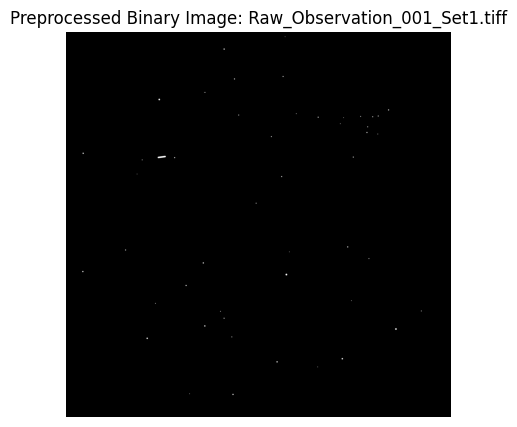

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set your image directory path
image_dir = Path(r"Datasets\Raw_Images")  # <-- change this to your actual folder path
image_paths = list(image_dir.glob("*.tiff"))
output_dir = Path(r"Processed")  # <-- change this to your actual folder path
# Output dictionary for processed binary images
preprocessed_images = {}
images_8bit = {}
pre_thres={}
# CLAHE setup
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for path in image_paths:
    # Load 16-bit grayscale image
    img_16 = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)

    if img_16 is None:
        print(f"Failed to load {path.name}")
        continue

    # Step 1: Normalize to 8-bit
    img_norm = cv2.normalize(img_16, None, 0, 255, cv2.NORM_MINMAX)
    img_8bit =  img_norm.astype(np.uint8)
    images_8bit[path.name] = img_8bit
    # Step 2: Gaussian Blur
    bilateral_filtered = cv2.bilateralFilter(img_8bit, 9, 75, 75)  # Adjust parameters as needed

    # Step 3: CLAHE
    clahe_img = clahe.apply(bilateral_filtered)
    pre_thres[path.name] = clahe_img
    hist = cv2.calcHist([clahe_img], [0], None, [256], [0, 256])
    hist = hist / hist.sum()  # Normalize to sum to 1 (optional)

# Step 3: Calculate the Cumulative Histogram
    cumulative_hist = np.cumsum(hist)

    # Step 4: Find the bin corresponding to the median
    median_bin = np.searchsorted(cumulative_hist, 0.5)

    
    # Step 4: Binary Thresholding
    _, binary = cv2.threshold(clahe_img, median_bin*2, 255, cv2.THRESH_BINARY)

    # Save binary output
    preprocessed_images[path.name] = binary
    output_path = output_dir / f"{path.stem}_binary.tiff"  # Save with _binary suffix
    cv2.imwrite(str(output_path), binary)


# Display one result for verification
sample_key = list(preprocessed_images.keys())[0]
plt.figure(figsize=(12, 5))
plt.imshow(preprocessed_images[sample_key], cmap='gray')
plt.title(f"Preprocessed Binary Image: {sample_key}")
plt.axis('off')
plt.show()


In [2]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from pathlib import Path
import os

# Parameters
area_threshold = 75  # minimum area to consider
eccentricity_threshold = 0.9  # classify based on this
min_dist = 10  # pixels to consider two centroids "too close"

# Setup paths
binary_dir = preprocessed_images  # dictionary: {filename: binary_image}
originals = images_8bit           # dictionary: {filename: 8bit_original}
stars_dir = Path("stars-images")
streaks_dir = Path("streaks-images")
stars_dir.mkdir(exist_ok=True)
streaks_dir.mkdir(exist_ok=True)

# Output data
all_eccentricity_data = []
all_image_stats = []

for image_name, binary in binary_dir.items():
    original = preprocessed_images[image_name]

    # Label connected components
    labels = label(binary)
    regions = regionprops(labels)

    star_objects = []
    streak_objects = []
    filtered_regions = []

    for region in regions:
        if region.area < area_threshold:
            continue

        centroid = region.centroid
        if any(np.linalg.norm(np.array(centroid) - np.array(r.centroid)) < min_dist for r in filtered_regions):
            continue  # Filter duplicates

        filtered_regions.append(region)
        eccentricity = region.eccentricity
        bbox = region.bbox
        x, y = int(centroid[0]), int(centroid[1])

        # Crop the region from original image
        crop = original[bbox[0]:bbox[2], bbox[1]:bbox[3]]

        if eccentricity < eccentricity_threshold:
            obj_type = "star"
            star_objects.append(region)
            save_path = stars_dir / f"star_{image_name[:-5]}_{x}_{y}.png"
        else:
            obj_type = "streak"
            streak_objects.append(region)
            save_path = streaks_dir / f"streak_{image_name[:-5]}_{x}_{y}.png"

        # Save cropped image
        cv2.imwrite(str(save_path), crop)

        # Log object data
        all_eccentricity_data.append({
            'image': image_name,
            'object_type': obj_type,
            'object_name': os.path.basename(save_path),
            'eccentricity': eccentricity
        })

    # Log image-wise summary
    all_image_stats.append({
        'image_name': image_name,
        'no_of_stars': len(star_objects),
        'no_of_streaks': len(streak_objects)
    })

# Save logs as CSVs
pd.DataFrame(all_eccentricity_data).to_csv('eccentricity_data.csv', index=False)
pd.DataFrame(all_image_stats).to_csv('image_stats.csv', index=False)

print("\n✅ Connected components processed. Cropped images and CSVs saved.")



✅ Connected components processed. Cropped images and CSVs saved.


In [3]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import os

# Directories
star_dir = Path("stars-images")
streak_dir = Path("streaks-images")

# Output list
feature_list = []

# Function to extract features from a grayscale image
def extract_features(image_path, label=None):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Threshold for contour detection
    _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    cnt = max(contours, key=cv2.contourArea)  # use largest contour
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h != 0 else 0
    area = cv2.contourArea(cnt)

    # Eccentricity
    M = cv2.moments(cnt)
    if M['mu20'] + M['mu02'] == 0:
        eccentricity = 0
    else:
        numerator = (M['mu20'] - M['mu02'])**2 + 4*M['mu11']**2
        denominator = (M['mu20'] + M['mu02'])**2
        eccentricity = np.sqrt(numerator / denominator) if denominator != 0 else 0

    # Hu Moments (log scaled)
    hu = cv2.HuMoments(M).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

    # Combine features
    features = {
        'file': image_path.name,
        'label': label,
        'aspect_ratio': aspect_ratio,
        'area': area,
        'eccentricity': eccentricity
    }

    for i, h in enumerate(hu):
        features[f'hu{i+1}'] = h

    return features

# Extract from star images
for path in star_dir.glob("*.png"):
    feat = extract_features(path, label="star")
    if feat: feature_list.append(feat)

# Extract from streak images
for path in streak_dir.glob("*.png"):
    feat = extract_features(path, label="streak")
    if feat: feature_list.append(feat)

# Convert to DataFrame
features_df = pd.DataFrame(feature_list)
features_df.to_csv("component_features.csv", index=False)

print("✅ Feature extraction complete. Saved to 'component_features.csv'.")


✅ Feature extraction complete. Saved to 'component_features.csv'.


In [4]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from pathlib import Path
import os

# Parameters
area_threshold = 75  # minimum area to consider
eccentricity_threshold = 0.9  # classify based on this
min_dist = 10  # pixels to consider two centroids "too close"
patch_size = 128  # desired output size for all patches

# Setup paths
binary_dir = preprocessed_images  # dictionary: {filename: binary_image}
originals = images_8bit           # dictionary: {filename: 8bit_original}
output_dir = Path("padd/annotated_images")
stars_dir = Path("padd/stars-images")
streaks_dir = Path("padd/streaks-images")
output_dir.mkdir(exist_ok=True)
stars_dir.mkdir(exist_ok=True)
streaks_dir.mkdir(exist_ok=True)

# Output data
all_eccentricity_data = []
all_image_stats = []

def pad_to_square(image, target_size=128):
    """Pad the image to target_size x target_size maintaining aspect ratio"""
    h, w = image.shape[:2]
    
    # Calculate padding amounts
    top = bottom = (target_size - h) // 2
    left = right = (target_size - w) // 2
    
    # Handle odd differences
    top_pad = bottom_pad = top
    left_pad = right_pad = left
    
    if (target_size - h) % 2 != 0:
        bottom_pad += 1
    if (target_size - w) % 2 != 0:
        right_pad += 1
    
    # Apply padding (works for both grayscale and color images)
    if len(image.shape) == 2:  # Grayscale
        padded = np.pad(image, 
                       ((top_pad, bottom_pad), (left_pad, right_pad)), 
                       mode='constant', 
                       constant_values=0)
    else:  # Color
        padded = np.pad(image, 
                       ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), 
                       mode='constant', 
                       constant_values=0)
    
    # Resize if needed (though padding should make it correct size)
    if padded.shape[0] != target_size or padded.shape[1] != target_size:
        padded = cv2.resize(padded, (target_size, target_size))
    
    return padded

for image_name, binary in binary_dir.items():
    original = originals[image_name]
    
    # Convert grayscale to BGR for color annotations if needed
    if len(original.shape) == 2:
        annotated_img = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    else:
        annotated_img = original.copy()
    
    # Label connected components
    labels = label(binary)
    regions = regionprops(labels)

    star_objects = []
    streak_objects = []
    filtered_regions = []

    for region in regions:
        if region.area < area_threshold:
            continue

        centroid = region.centroid
        if any(np.linalg.norm(np.array(centroid) - np.array(r.centroid)) < min_dist for r in filtered_regions):
            continue  # Filter duplicates

        filtered_regions.append(region)
        eccentricity = region.eccentricity
        bbox = region.bbox
        y1, x1, y2, x2 = bbox  # Note: regionprops uses (min_row, min_col, max_row, max_col)
        
        # Convert to (x,y,w,h) format for OpenCV
        x, y, w, h = x1, y1, x2 - x1, y2 - y1
        
        # Crop the region from original image with boundary checks
        y1 = max(0, y1)
        x1 = max(0, x1)
        y2 = min(original.shape[0], y2)
        x2 = min(original.shape[1], x2)
        crop = original[y1:y2, x1:x2]

        # Pad the cropped image to 128x128
        padded_crop = pad_to_square(crop, patch_size)

        if eccentricity < eccentricity_threshold:
            obj_type = "star"
            color = (0, 255, 0)  # Green for stars
            star_objects.append(region)
            save_path = stars_dir / f"star_{image_name[:-5]}_{x}_{y}.png"
        else:
            obj_type = "streak"
            color = (0, 0, 255)  # Red for streaks
            streak_objects.append(region)
            save_path = streaks_dir / f"streak_{image_name[:-5]}_{x}_{y}.png"

        # Draw bounding box
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
        
        # Add label text
        label_text = f"{obj_type} {eccentricity:.2f}"
        cv2.putText(annotated_img, label_text, (x1, y1 - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        
        # Save padded cropped image
        cv2.imwrite(str(save_path), padded_crop)

        # Log object data
        all_eccentricity_data.append({
            'image': image_name,
            'object_type': obj_type,
            'object_name': os.path.basename(save_path),
            'eccentricity': eccentricity,
            'bbox_x': x1,
            'bbox_y': y1,
            'bbox_width': w,
            'bbox_height': h,
            'padded_size': patch_size
        })

    # Save annotated image
    annotated_path = output_dir / f"annotated_{image_name}"
    cv2.imwrite(str(annotated_path), annotated_img)
    
    # Log image-wise summary
    all_image_stats.append({
        'image_name': image_name,
        'no_of_stars': len(star_objects),
        'no_of_streaks': len(streak_objects)
    })

# Save logs as CSVs
pd.DataFrame(all_eccentricity_data).to_csv('eccentricity_data.csv', index=False)
pd.DataFrame(all_image_stats).to_csv('image_stats.csv', index=False)

print("\n✅ Processing complete. Annotated images, 128x128 padded object patches, and CSVs saved.") 


✅ Processing complete. Annotated images, 128x128 padded object patches, and CSVs saved.



✅ Processing complete. Annotated images, cropped objects, and CSVs saved.


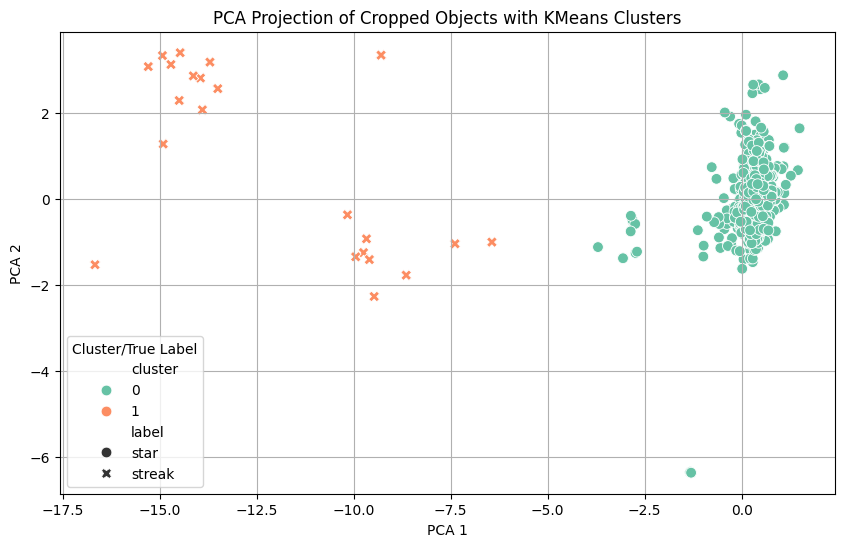

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Load extracted features
df = pd.read_csv("component_features.csv")

# Preserve true labels for comparison
true_labels = df['label']

# Select only numerical features (ignore filename + label)
X = df.drop(columns=['file', 'label'])

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, true_labels, test_size=0.2, random_state=42)

# KMeans clustering (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=4)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', style=true_labels, palette='Set2', s=60)
plt.title("PCA Projection of Cropped Objects with KMeans Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster/True Label')
plt.grid(True)
plt.show()


In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Majority voting to map cluster ID → actual label (star/streak)
cluster_to_label = {}

for cluster_id in df['cluster'].unique():
    actual_labels = df[df['cluster'] == cluster_id]['label']
    most_common = actual_labels.value_counts().idxmax()
    cluster_to_label[cluster_id] = most_common

print("🔁 Cluster-to-Label Mapping (Majority Vote):", cluster_to_label)

# Map clusters to predicted labels
df['predicted_label'] = df['cluster'].map(cluster_to_label)

# Confusion Matrix
cm = confusion_matrix(df['label'], df['predicted_label'], labels=['star', 'streak'])
report = classification_report(df['label'], df['predicted_label'], target_names=['star', 'streak'])

print("\n🧾 Confusion Matrix:")
print(pd.DataFrame(cm, index=['Actual Star', 'Actual Streak'], columns=['Predicted Star', 'Predicted Streak']))

print("\n📊 Classification Report:")
print(report)


🔁 Cluster-to-Label Mapping (Majority Vote): {np.int32(0): 'star', np.int32(1): 'streak'}

🧾 Confusion Matrix:
               Predicted Star  Predicted Streak
Actual Star              1027                 0
Actual Streak               0                23

📊 Classification Report:
              precision    recall  f1-score   support

        star       1.00      1.00      1.00      1027
      streak       1.00      1.00      1.00        23

    accuracy                           1.00      1050
   macro avg       1.00      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050



In [27]:
# Select relevant columns for export
output_df = df[['file', 'label', 'predicted_label', 'cluster', 'pca1', 'pca2']]

# Save to CSV
output_df.to_csv("clustered_predictions.csv", index=False)

print("✅ Clustered predictions saved to 'clustered_predictions.csv'.")


✅ Clustered predictions saved to 'clustered_predictions.csv'.


**USED THRESHOLD PATCHES TO TRAIN**

In [37]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
random_seed = 4 
random.seed(random_seed)
 
np.random.seed(random_seed)
 
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- DATASET ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 1 channel input
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ImageFolder assumes each class is in a folder
dataset = datasets.ImageFolder(root=r'Data\Dataset_thresh', transform=transform)

# Print class mapping
print("✅ Classes:", dataset.classes)  # ['stars-images', 'streaks-images']

# --- SPLIT ---
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])


from torch.utils.data import WeightedRandomSampler
from collections import Counter

train_targets = [dataset.targets[i] for i in train_ds.indices]
class_sample_count = Counter(train_targets)

# Inverse frequency for sampling
weights = [1.0 / class_sample_count[t] for t in train_targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoader with sampler
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32)

    
# --- MODEL ---
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
model = resnet18.to(device)

# --- TRAINING SETUP ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5

best_val_acc = 0.0

# --- TRAIN LOOP ---
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # --- VALIDATION ---
    model.eval()
    correct = 0
    total = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_starstreak_model.pth")

# --- EVALUATION ---
print("\n📊 Final Classification Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes))


✅ Classes: ['stars', 'streaks']


c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Loss: 0.0474 - Val Acc: 0.9812
Epoch 2/5 - Loss: 0.0005 - Val Acc: 0.9906
Epoch 3/5 - Loss: 0.0002 - Val Acc: 0.9906
Epoch 4/5 - Loss: 0.0001 - Val Acc: 0.9906
Epoch 5/5 - Loss: 0.0001 - Val Acc: 1.0000

📊 Final Classification Report:
              precision    recall  f1-score   support

       stars       1.00      1.00      1.00       209
     streaks       1.00      1.00      1.00         4

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213



**RAW DATASET**

*without augment*

✅ Classes: ['stars', 'streaks']


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [76]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from sklearn.metrics import classification_report
from collections import Counter

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- MODEL CLASS ---
class StarStreakClassifier(nn.Module):
    def __init__(self):
        super(StarStreakClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        
    def forward(self, x):
        return self.model(x)

# --- DATASET ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset with error handling
try:
    dataset = datasets.ImageFolder(root='Data/Dataset_Raw_Augment', transform=transform)
    print("✅ Classes:", dataset.classes)
    print(f"✅ Total samples: {len(dataset)}")
    
    if len(dataset) == 0:
        raise ValueError("Dataset is empty! Check your 'Data' directory structure.")
        
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()

# --- SPLIT ---
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Add check for minimum dataset size
if train_size == 0 or val_size == 0:
    raise ValueError("Not enough samples for training and validation split")

train_ds, val_ds = random_split(dataset, [train_size, val_size])

# --- SAMPLER ---
# Get labels from the original dataset (not the split)

train_targets = [dataset.targets[i] for i in train_ds.indices]
class_sample_count = Counter(train_targets)

print(f"✅ Class sample counts: {class_sample_count}")
# Inverse frequency for sampling
weights = [1.0 / class_sample_count[t] for t in train_targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoader with sampler
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32)

print(f"\nDataset sizes - Train: {len(train_ds)}, Val: {len(val_ds)}")


✅ Classes: ['stars', 'streaks']
✅ Total samples: 2225
✅ Class sample counts: Counter({0: 1461, 1: 319})

Dataset sizes - Train: 1780, Val: 445


c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Loss: 0.0885 - Val Acc: 0.9820
Epoch 2/5 - Loss: 0.0069 - Val Acc: 1.0000
Epoch 3/5 - Loss: 0.0072 - Val Acc: 1.0000
Epoch 4/5 - Loss: 0.0011 - Val Acc: 1.0000
Epoch 5/5 - Loss: 0.0012 - Val Acc: 1.0000

📊 Final Classification Report:
              precision    recall  f1-score   support

       stars       1.00      1.00      1.00       359
     streaks       1.00      1.00      1.00        86

    accuracy                           1.00       445
   macro avg       1.00      1.00      1.00       445
weighted avg       1.00      1.00      1.00       445



In [79]:
from torch.utils.data import Subset
import numpy as np

# --- MANUAL UNDERSAMPLING ---
# Extract targets from training set
targets = [dataset.targets[i] for i in train_ds.indices]
class_sample_count = Counter(targets)
print("Original train class distribution:", class_sample_count)

# Find the minority class count
min_class_count = min(class_sample_count.values())

# Build balanced indices
balanced_indices = []
class_indices = {cls: [] for cls in class_sample_count}

for idx in train_ds.indices:
    label = dataset.targets[idx]
    class_indices[label].append(idx)

# Undersample each class
for cls, indices in class_indices.items():
    undersampled = np.random.choice(indices, min_class_count, replace=False)
    balanced_indices.extend(undersampled)

# Create new subset with balanced indices
train_ds = Subset(dataset, balanced_indices)
print("Balanced train class distribution:",
      Counter([dataset.targets[i] for i in train_ds.indices]))

Original train class distribution: Counter({0: 1461, 1: 319})
Balanced train class distribution: Counter({0: 319, 1: 319})


In [40]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt

# Force CPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available = lambda: False  # Override CUDA check

# --- MODEL CLASS ---
class StarStreakClassifier(nn.Module):
    def __init__(self):
        super(StarStreakClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        
    def forward(self, x):
        return self.model(x)

# --- CALLBACKS ---
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > (self.best_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class LRScheduler:
    def __init__(self, optimizer, patience=3, factor=0.1, min_lr=1e-6):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self._reduce_lr()
                self.counter = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)
            param_group['lr'] = new_lr
            print(f"\nReducing learning rate from {old_lr:.2e} to {new_lr:.2e}")

# --- DATASET ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
try:
    dataset = datasets.ImageFolder(root='padd', transform=transform)
    print("✅ Classes:", dataset.classes)
    print(f"✅ Total samples: {len(dataset)}")
    
    if len(dataset) == 0:
        raise ValueError("Dataset is empty!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()

# --- SPLIT ---
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# --- BALANCE TRAINING SET ---
targets = [dataset.targets[i] for i in train_ds.indices]
class_sample_count = Counter(targets)
min_class_count = min(class_sample_count.values())

balanced_indices = []
class_indices = {cls: [] for cls in class_sample_count}

for idx in train_ds.indices:
    label = dataset.targets[idx]
    class_indices[label].append(idx)

for cls, indices in class_indices.items():
    balanced_indices.extend(np.random.choice(indices, min_class_count, replace=False))

train_ds = Subset(dataset, balanced_indices)

# --- DATALOADERS ---
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"\nDataset sizes - Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# --- TRAINING SETUP ---
model = StarStreakClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
early_stopping = EarlyStopping(patience=7, min_delta=0.001)
lr_scheduler = LRScheduler(optimizer)

# --- TRAINING METRICS TRACKING ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
num_epochs = 30

for epoch in range(num_epochs):
    # --- TRAIN PHASE ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # --- CALLBACKS ---
    early_stopping(epoch_val_loss)
    lr_scheduler(epoch_val_loss)
    
    # --- PRINT PROGRESS ---
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_model_augment_noiseless.pth')
        
    # Early stopping check
    if early_stopping.early_stop:
        print(f"⏹ Early stopping triggered after {epoch+1} epochs")
        break

# --- PLOT TRAINING CURVES ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_metrics.png')
plt.close()


✅ Classes: ['stars', 'streaks']
✅ Total samples: 1395

Dataset sizes - Train: 524, Val: 209, Test: 210

Epoch 1/30
Train Loss: 0.2717 | Val Loss: 1.7919
Train Acc: 0.8893 | Val Acc: 0.2632
Learning Rate: 1.00e-04

Epoch 2/30
Train Loss: 0.0383 | Val Loss: 5.5130
Train Acc: 0.9905 | Val Acc: 0.2679
Learning Rate: 1.00e-04

Epoch 3/30
Train Loss: 0.0092 | Val Loss: 3.7048
Train Acc: 0.9981 | Val Acc: 0.3636
Learning Rate: 1.00e-04

Epoch 4/30
Train Loss: 0.0046 | Val Loss: 0.0089
Train Acc: 1.0000 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 5/30
Train Loss: 0.0015 | Val Loss: 0.0011
Train Acc: 1.0000 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 6/30
Train Loss: 0.0016 | Val Loss: 0.0008
Train Acc: 1.0000 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 7/30
Train Loss: 0.0012 | Val Loss: 0.0006
Train Acc: 1.0000 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 8/30
Train Loss: 0.0008 | Val Loss: 0.0006
Train Acc: 1.0000 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 9/30
Train

In [83]:

# --- FINAL EVALUATION ---
model.load_state_dict(torch.load('best_model_augment_noiseless.pth'))
model.eval()

# Test set evaluation
test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print("\n📊 Final Validation Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes))

print("\n📊 Test Set Report:")
print(classification_report(test_labels, test_preds, target_names=dataset.classes))


📊 Final Validation Report:
              precision    recall  f1-score   support

       stars       1.00      1.00      1.00       262
     streaks       1.00      1.00      1.00        71

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333


📊 Test Set Report:
              precision    recall  f1-score   support

       stars       1.00      1.00      1.00       277
     streaks       1.00      1.00      1.00        58

    accuracy                           1.00       335
   macro avg       1.00      1.00      1.00       335
weighted avg       1.00      1.00      1.00       335



**ADDING NOISE**

In [42]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt

# Force CPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available = lambda: False  # Override CUDA check

# --- MODEL CLASS ---
class StarStreakClassifier(nn.Module):
    def __init__(self):
        super(StarStreakClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 4)
        
    def forward(self, x):
        return self.model(x)

# --- CALLBACKS ---
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > (self.best_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class LRScheduler:
    def __init__(self, optimizer, patience=3, factor=0.1, min_lr=1e-6):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self._reduce_lr()
                self.counter = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)
            param_group['lr'] = new_lr
            print(f"\nReducing learning rate from {old_lr:.2e} to {new_lr:.2e}")

# --- DATASET ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
try:
    dataset = datasets.ImageFolder(root='padd', transform=transform)
    print("✅ Classes:", dataset.classes)
    print(f"✅ Total samples: {len(dataset)}")
    
    if len(dataset) == 0:
        raise ValueError("Dataset is empty!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()

# --- SPLIT ---
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# --- BALANCE TRAINING SET ---
targets = [dataset.targets[i] for i in train_ds.indices]

class_sample_count = Counter(targets)
min_class_count = min(class_sample_count.values())

print("Original class counts:", class_sample_count)
balanced_indices = []
class_indices = {cls: [] for cls in class_sample_count}

for idx in train_ds.indices:
    label = dataset.targets[idx]
    class_indices[label].append(idx)

for cls, indices in class_indices.items():
    balanced_indices.extend(np.random.choice(indices, min_class_count, replace=False))
balanced_targets = [dataset.targets[i] for i in balanced_indices]
balanced_class_count = Counter(balanced_targets)
print("Balanced class counts:", balanced_class_count)
train_ds = Subset(dataset, balanced_indices)

# --- DATALOADERS ---
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"\nDataset sizes - Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# --- TRAINING SETUP ---
model = StarStreakClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
lr_scheduler = LRScheduler(optimizer)

# --- TRAINING METRICS TRACKING ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
num_epochs = 30

for epoch in range(num_epochs):
    # --- TRAIN PHASE ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # --- CALLBACKS ---
    early_stopping(epoch_val_loss)
    lr_scheduler(epoch_val_loss)
    
    # --- PRINT PROGRESS ---
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(),'best_model_augment_noise.pth')
        
    # Early stopping check
    if early_stopping.early_stop:
        print(f"⏹ Early stopping triggered after {epoch+1} epochs")
        break

# --- PLOT TRAINING CURVES ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_metrics.png')
plt.close()


✅ Classes: ['background', 'noise', 'stars', 'streaks']
✅ Total samples: 2495
Original class counts: Counter({2: 718, 1: 420, 0: 349, 3: 259})
Balanced class counts: Counter({2: 259, 1: 259, 3: 259, 0: 259})

Dataset sizes - Train: 1036, Val: 374, Test: 375

Epoch 1/30
Train Loss: 0.1895 | Val Loss: 2.0255
Train Acc: 0.9363 | Val Acc: 0.5909
Learning Rate: 1.00e-04

Epoch 2/30
Train Loss: 0.0364 | Val Loss: 0.0206
Train Acc: 0.9875 | Val Acc: 0.9920
Learning Rate: 1.00e-04

Epoch 3/30
Train Loss: 0.0218 | Val Loss: 0.0064
Train Acc: 0.9961 | Val Acc: 0.9973
Learning Rate: 1.00e-04

Epoch 4/30
Train Loss: 0.0097 | Val Loss: 0.0075
Train Acc: 0.9981 | Val Acc: 0.9973
Learning Rate: 1.00e-04

Epoch 5/30
Train Loss: 0.0035 | Val Loss: 0.0154
Train Acc: 1.0000 | Val Acc: 0.9947
Learning Rate: 1.00e-04

Reducing learning rate from 1.00e-04 to 1.00e-05

Epoch 6/30
Train Loss: 0.0044 | Val Loss: 0.0120
Train Acc: 0.9990 | Val Acc: 0.9973
Learning Rate: 1.00e-05
⏹ Early stopping triggered after 

In [106]:

# --- FINAL EVALUATION ---
model.load_state_dict(torch.load('best_model_augment_noise.pth'))
model.eval()

# Test set evaluation
test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print("\n📊 Final Validation Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes))

print("\n📊 Test Set Report:")
print(classification_report(test_labels, test_preds, target_names=dataset.classes))


train_preds, train_labels = [], []
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

print("\n📊 Train Set Report:")
print(classification_report(train_labels, train_preds, target_names=dataset.classes))


📊 Final Validation Report:
              precision    recall  f1-score   support

  background       1.00      0.97      0.99        76
       noise       1.00      1.00      1.00       102
       stars       1.00      1.00      1.00       260
     streaks       0.97      1.00      0.98        60

    accuracy                           1.00       498
   macro avg       0.99      0.99      0.99       498
weighted avg       1.00      1.00      1.00       498


📊 Test Set Report:
              precision    recall  f1-score   support

  background       1.00      1.00      1.00        75
       noise       1.00      1.00      1.00        84
       stars       1.00      0.99      1.00       281
     streaks       0.97      1.00      0.98        60

    accuracy                           1.00       500
   macro avg       0.99      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


📊 Train Set Report:
              precision    recall  f1-score   support

  back

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, set_name="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(set_name)
    plt.show()


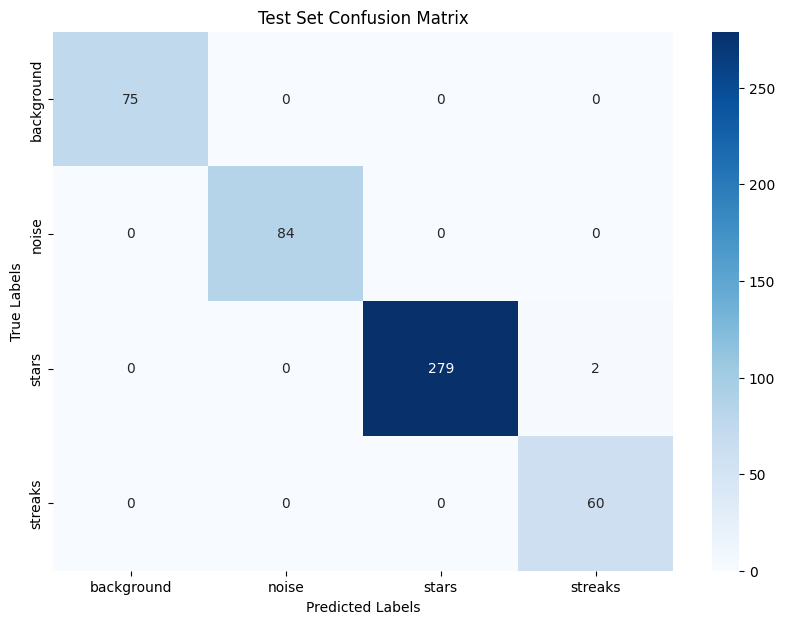

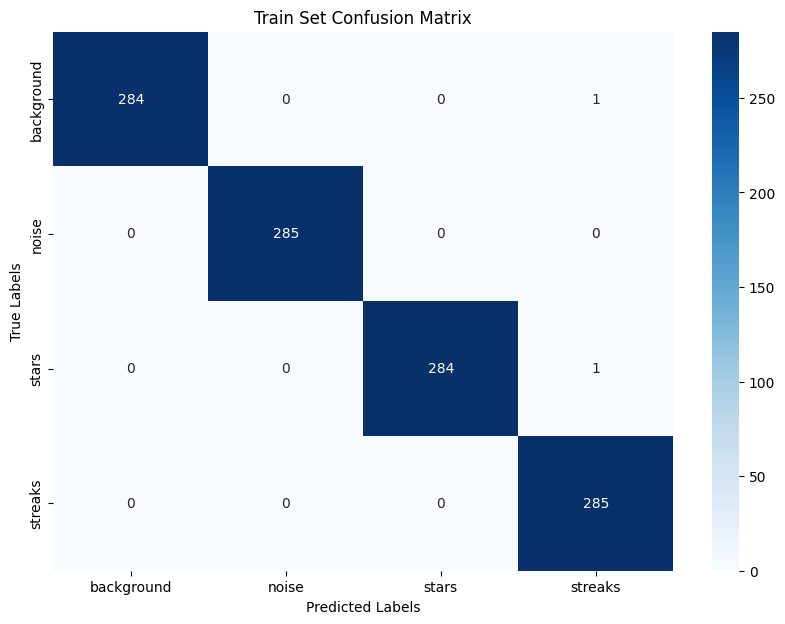

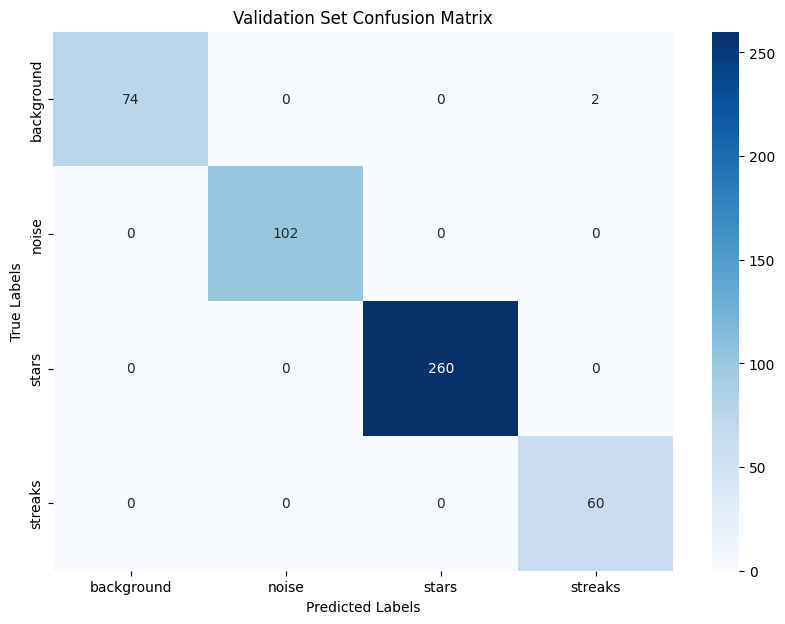

In [108]:
# For Test Set
plot_confusion_matrix(test_labels, test_preds, dataset.classes, "Test Set Confusion Matrix")

# Optionally for Train and Validation:
plot_confusion_matrix(train_labels, train_preds, dataset.classes, "Train Set Confusion Matrix")
plot_confusion_matrix(val_labels, val_preds, dataset.classes, "Validation Set Confusion Matrix")


In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from pathlib import Path
# Load model class if not already imported
# from model_file import StarStreakClassifier

# Load trained model
model = StarStreakClassifier()
model.load_state_dict(torch.load('best_model_augment_noise.pth'))
model.eval()

# Move to CPU explicitly since you're forcing CPU mode
device = torch.device('cpu')
model.to(device)

# Define class labels (update based on your actual dataset)
class_names = ['background', 'noise', 'stars', 'streaks']

# CLAHE setup
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
lahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# --- Image Preprocessing + Patch Annotation ---
def preprocess_and_patch(image_path, patch_size=128):
    # Step 1: Read 16-bit image
    img_16 = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
    if img_16 is None:
        raise FileNotFoundError(f"Failed to load {image_path}")
    
    # Step 2: Normalize to 8-bit
    img_norm = cv2.normalize(img_16, None, 0, 255, cv2.NORM_MINMAX)
    img_8bit = img_norm.astype(np.uint8)

    # Step 3: Bilateral Filter
    bilateral_filtered = cv2.bilateralFilter(img_8bit, 9, 75, 75)

    # Step 4: CLAHE
    clahe_img = clahe.apply(bilateral_filtered)
    hist = cv2.calcHist([clahe_img], [0], None, [256], [0, 256])
    hist = hist / hist.sum()  # Normalize to sum to 1 (optional)

    # Step 3: Calculate the Cumulative Histogram
    cumulative_hist = np.cumsum(hist)

    # Step 4: Find the bin corresponding to the median
    median_bin = np.searchsorted(cumulative_hist, 0.5)

    
    # Step 4: Binary Thresholding
    _, binary = cv2.threshold(clahe_img, 10, 255, cv2.THRESH_BINARY)

    # Step 5: Patch Extraction and Prediction
    h, w = binary.shape
    annotated_image = np.zeros((h, w, 3), dtype=np.uint8)
    predictions_map = np.full((h // patch_size, w // patch_size), -1)

    transform_patch = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = binary[i:i+patch_size, j:j+patch_size]
            
            # Skip if patch is smaller than required (e.g., edge cases)
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue

            input_tensor = transform_patch(patch).unsqueeze(0)
            with torch.no_grad():
                output = model(input_tensor)
                predicted_class = output.argmax(dim=1).item()
                predictions_map[i // patch_size, j // patch_size] = predicted_class

                # Color annotation (you can define a palette)
                color_map = [
                    (255, 0, 0),    # Class 0 - Red
                    (0, 255, 0),    # Class 1 - Green
                    (0, 0, 255),    # Class 2 - Blue
                    (255, 255, 0)   # Class 3 - Yellow
                ]
                color = color_map[predicted_class]
                cv2.rectangle(annotated_image, (j, i), (j+patch_size, i+patch_size), color, thickness=cv2.)

    return clahe_img, annotated_image, predictions_map

from matplotlib import pyplot as plt

image_path = Path(r"Datasets\Raw_Images\Raw_Observation_004_Set1.tiff")  # Replace with your image path

original, annotated, patch_map = preprocess_and_patch(image_path)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.title("Preprocessed Image")

plt.subplot(1, 2, 2)
plt.imshow(annotated)
plt.title("Patch-wise Annotations")
plt.show()


c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Argument 'thickness' is required to be an integer
>  - argument for rectangle() given by name ('thickness') and position (4)
>  - Argument 'thickness' is required to be an integer
>  - argument for rectangle() given by name ('thickness') and position (4)


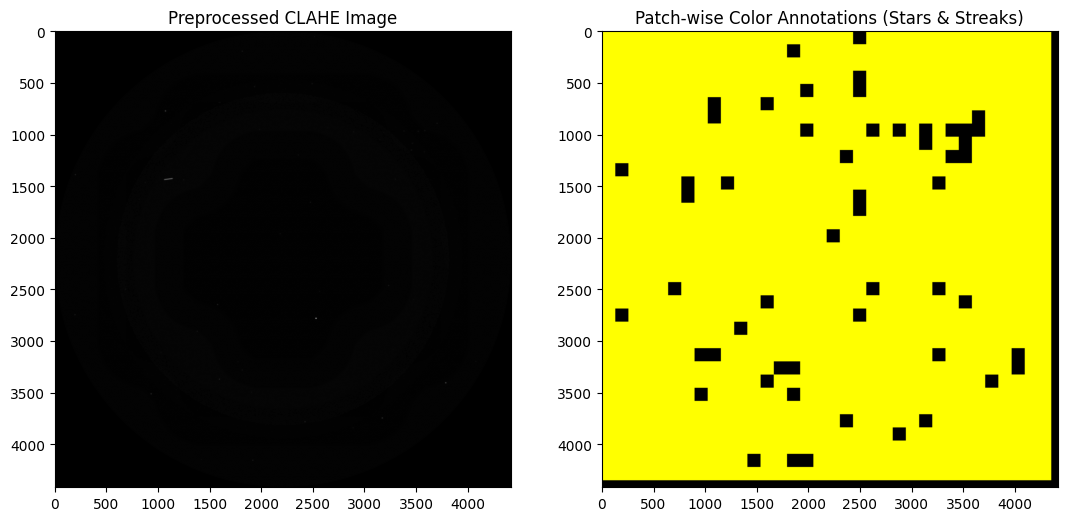

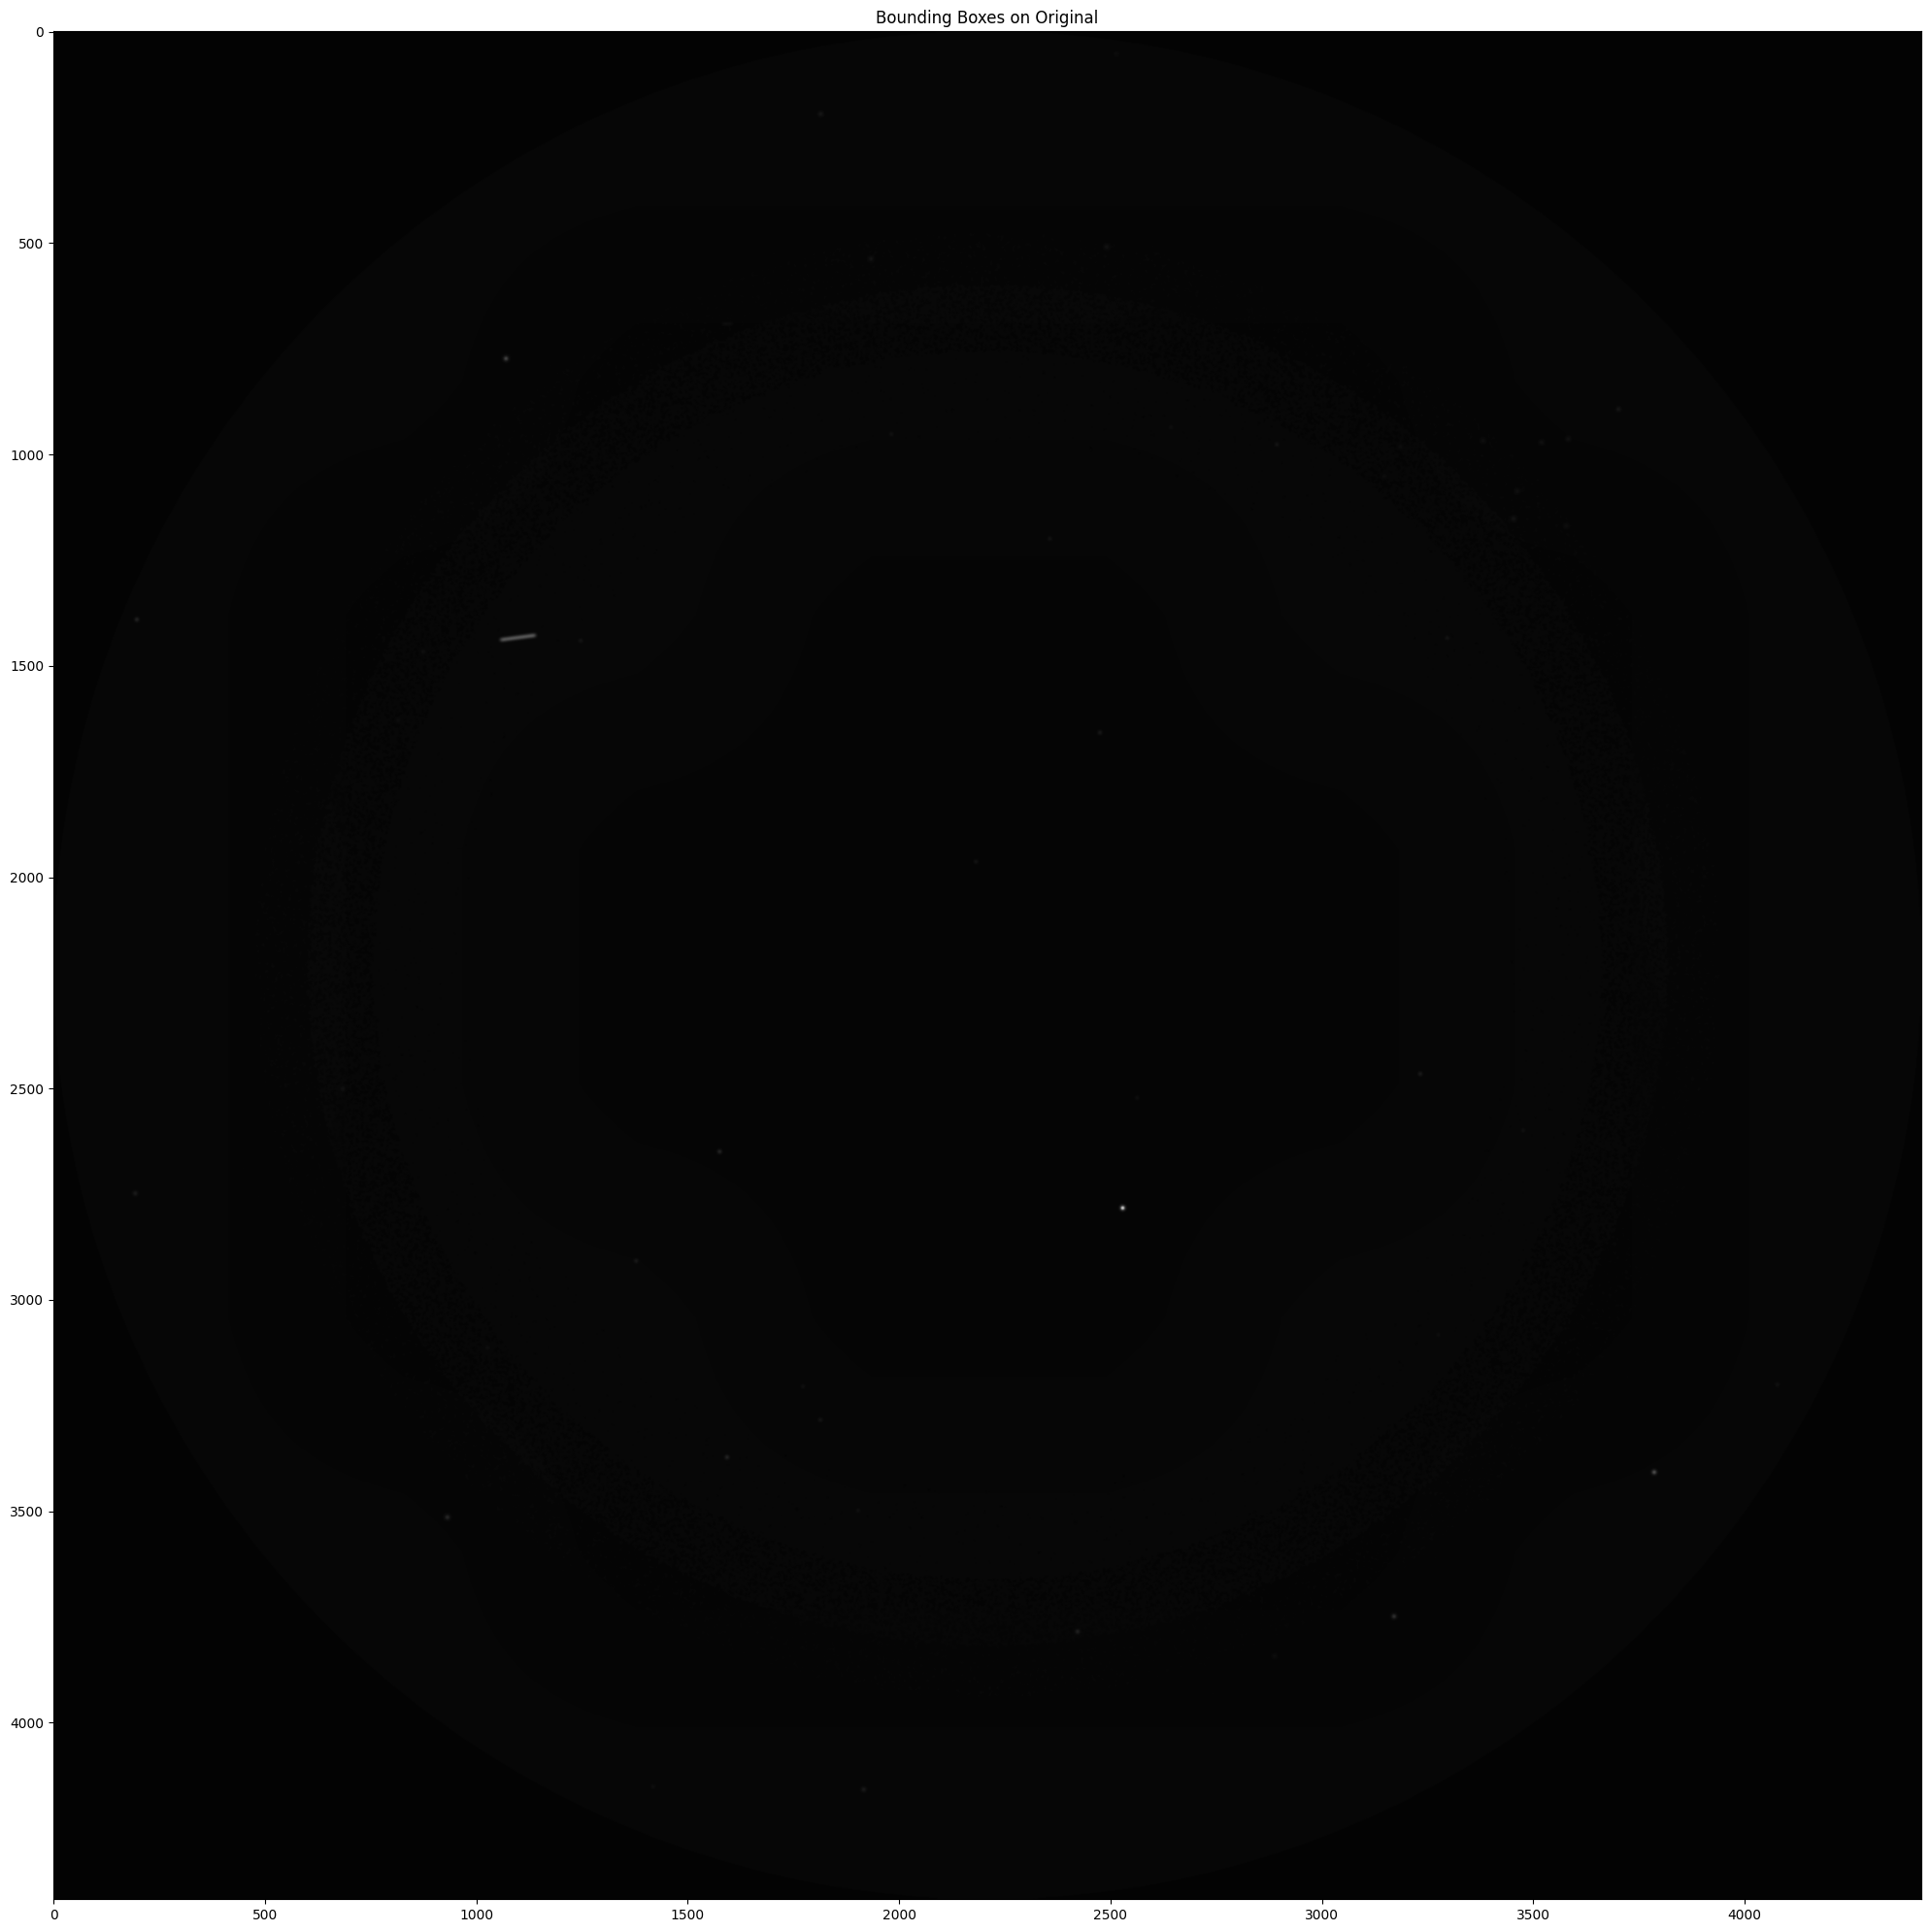

In [7]:

plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(original, cmap='gray')
plt.title("Preprocessed CLAHE Image")

plt.subplot(1, 3, 2)
plt.imshow(annotated)
plt.title("Patch-wise Color Annotations (Stars & Streaks)")

plt.figure(figsize=(20,20))
plt.imshow(bbox_overlay)
plt.title("Bounding Boxes on Original")

plt.tight_layout()
plt.show()


Predicted Class: 3, Label: streaks
